In [31]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# setting up notebook variables
date_chosen = '2025-05-06'

Let's begin by setting up some quick stats on ERCOT and visuals!

In [3]:
# loading in ercot lmp data
# next step will be to set up function to concat all datafiles and output as df here
ercot_data=pl.read_csv(f'datasets/ercot_lmp_data/lmp_node_zone_hub_csv/{date_chosen}_lmp_node_zone_hub.csv')

In [4]:
def transform_ercot_data(ercot_df: object):
    '''
    given ercot df or file, return a transformed verion
    changes scedtimestamp to datetime type...
    '''

    ercot_df = ercot_df.rename(
        {"LMP": "5min_lmp",
         "settlementPoint": "node_id",
         "SCEDTimestamp": "timestamp"
         })
    
    # removing the seconds of ERCOT time stamp, causing issues....
    ercot_df = ercot_df.with_columns(
        pl.col("timestamp").str.replace(r'..$', "00")
    )
    
    ercot_df = ercot_df.with_columns(
        pl.col("timestamp").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S")
    )
    
    ercot_df = ercot_df.with_columns(
        pl.lit("ERCOT").alias("iso_id"),
        pl.col('timestamp').dt.hour().alias('hour')
    )

    return ercot_df

In [5]:
# quick info on data set
ercot_data=transform_ercot_data(ercot_df=ercot_data)
ercot_data.describe()

statistic,timestamp,repeatHourFlag,node_id,5min_lmp,iso_id,hour
str,str,f64,str,f64,str,f64
"""count""","""291582""",291582.0,"""291582""",291582.0,"""291582""",291582.0
"""null_count""","""0""",0.0,"""0""",0.0,"""0""",0.0
"""mean""","""2025-05-06 11:42:42.680412""",0.0,null,38.23923,null,11.254296
"""std""",null,null,null,64.982236,null,6.726679
"""min""","""2025-05-06 00:00:00""",0.0,"""7RNCHSLR_ALL""",-5586.28,"""ERCOT""",0.0
"""25%""","""2025-05-06 05:55:00""",null,null,18.01,null,5.0
"""50%""","""2025-05-06 11:45:00""",null,null,23.74,null,11.0
"""75%""","""2025-05-06 17:35:00""",null,null,37.52,null,17.0
"""max""","""2025-05-06 23:15:00""",0.0,"""ZIER_SLR_ALL""",5624.16,"""ERCOT""",23.0


In [6]:
# creating a list of the main load zones/trading hubs for LMPs
# these are the main hubs and will be used so that we can track correlation
ercot_hubs = [
    "HB_BUSAVG",
    "HB_HOUSTON", 	
    "HB_HUBAVG",	
    "HB_NORTH",	
    "HB_PAN",
    "HB_SOUTH", 	
    "HB_WEST", 	
    "LZ_AEN", 	
    "LZ_CPS", 	
    "LZ_HOUSTON",	
    "LZ_LCRA", 	
    "LZ_NORTH", 	
    "LZ_RAYBN",	
    "LZ_SOUTH", 	
    "LZ_WEST",
]

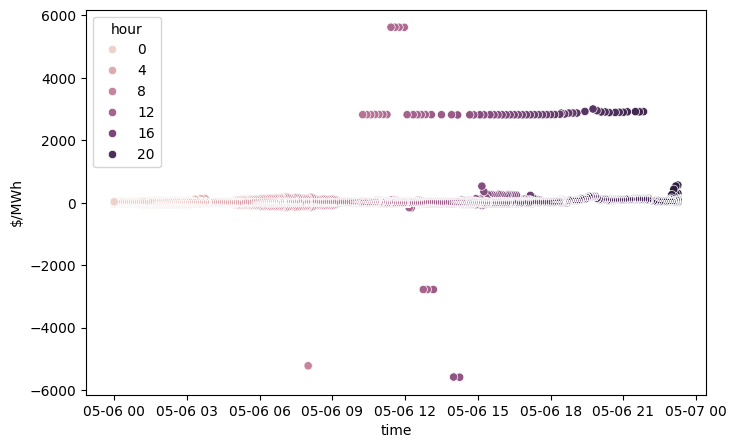

In [7]:
# now let's plot data
plt.figure(figsize=[8,5])

sns.scatterplot(data=ercot_data, x='timestamp', y='5min_lmp', hue='hour')

plt.xlabel('time')
plt.ylabel('$/MWh')

plt.show()

<Figure size 640x480 with 0 Axes>

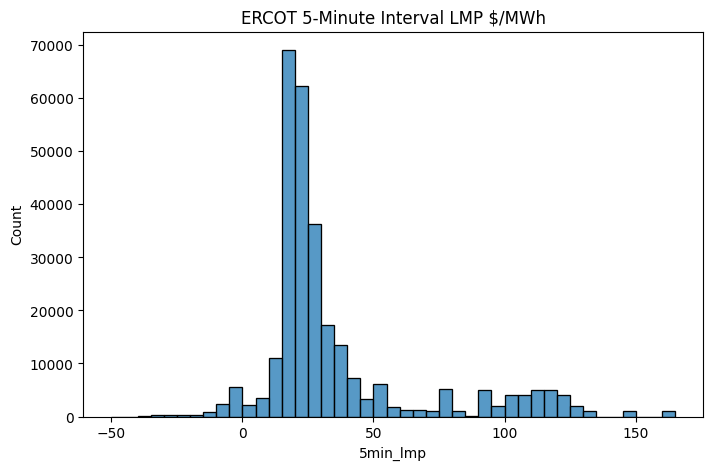

<Figure size 640x480 with 0 Axes>

In [8]:
# lets plot distribution of pricing
plt.figure(figsize=[8,5])

bins=range(-50, 170, 5)
sns.histplot(data=ercot_data, x='5min_lmp', bins=bins, kde=False, hue_norm='hour')

plt.title("ERCOT 5-Minute Interval LMP $/MWh")
plt.figure()

In [9]:
# let's filter for only trading hub/zone data on LMPs
ercot_main_hubs = ercot_data.filter(
    pl.col('node_id').is_in(ercot_hubs)
)

ercot_main_hubs.describe()

statistic,timestamp,repeatHourFlag,node_id,5min_lmp,iso_id,hour
str,str,f64,str,f64,str,f64
"""count""","""4365""",4365.0,"""4365""",4365.0,"""4365""",4365.0
"""null_count""","""0""",0.0,"""0""",0.0,"""0""",0.0
"""mean""","""2025-05-06 11:42:42.680412""",0.0,null,38.138586,null,11.254296
"""std""",null,null,null,36.700405,null,6.727438
"""min""","""2025-05-06 00:00:00""",0.0,"""HB_BUSAVG""",-118.43,"""ERCOT""",0.0
"""25%""","""2025-05-06 05:55:00""",null,null,18.49,null,5.0
"""50%""","""2025-05-06 11:45:00""",null,null,23.54,null,11.0
"""75%""","""2025-05-06 17:35:00""",null,null,36.04,null,17.0
"""max""","""2025-05-06 23:15:00""",0.0,"""LZ_WEST""",210.52,"""ERCOT""",23.0


We now want to create heat maps to visualize correlations. We want to identify the following: 
1. identify nodes with consistent lower or higher LMP pricing
2. daily price patterns across all nodes
3. outlier hours or nodes with unusual pricing

In [60]:
# creating a function where, given a dataframe with data, return necessary framework
# to process dfs
def lmp_node_hour_hmap(dataframe: object, plot_title: None):
    '''
    Args
        provide a dataframe in polars format and it will make transformations

    Output
        provides user with necessary objects needed to visualize correlations

    Needed: nodenames as node_id, hour values as hour and 5min lmps as 5min_lmp
    provide a title for the plot
    '''
    # group by node_id and hour then calculate mean of lmp values
    pandas_df = dataframe.to_pandas()

    pivot_df = pd.pivot_table(
        pandas_df, values='5min_lmp', index='node_id', columns='hour', aggfunc='mean'
    )

    plt.figure(figsize=[12,4])

    ax = sns.heatmap(ercot_hmap_df, cmap='coolwarm', fmt='.0f',
                    annot=True, linewidths=0.5)
    
    plt.title(f'{plot_title}')

    plt.show()

    return pivot_df


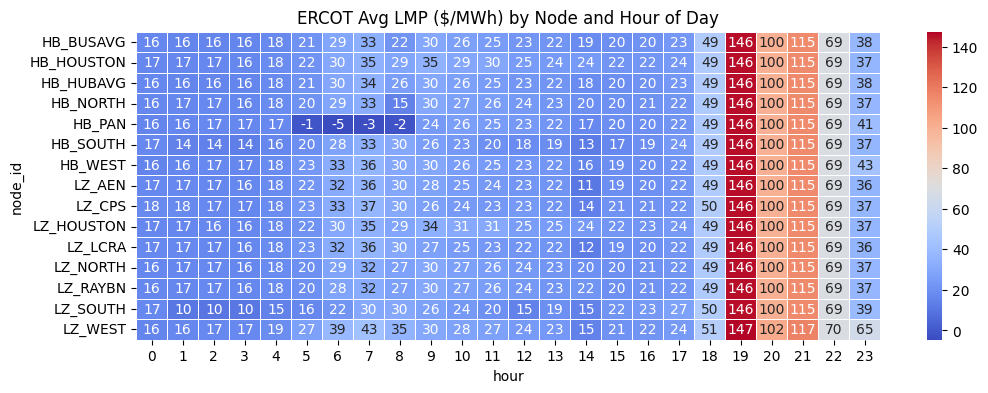

In [61]:
ercot_hmap_df = lmp_node_hour_hmap(dataframe=ercot_main_hubs, 
                         plot_title='ERCOT Avg LMP ($/MWh) by Node and Hour of Day')

In [77]:
def lmp_corr_matrix(dataframe: object, index=None, columns=None):
    '''
    Returns a correlation matrix
    '''
    pandas_df = dataframe.to_pandas()

    # create pivot table with timestamps as rows and nodes as columns

    if index == None or columns == None:
        node_pivot = pd.pivot_table(
            data=pandas_df, values='5min_lmp', index='hour', columns='node_id', 
            aggfunc='mean'
        )

    else: 
        node_pivot = pd.pivot_table(
            data=pandas_df, values='5min_lmp', index=f'{index}', columns=f'{columns}', 
            aggfunc='mean'
        )
        
    # correlation matrix
    corr_matrix = node_pivot.corr()

    plt.figure(figsize=[20, 4])

    sns.heatmap(data=corr_matrix, annot=False, cmap='viridis', square=True, 
                linewidth=0.5, vmin=-1, vmax=1)
    
    plt.show()

    return corr_matrix

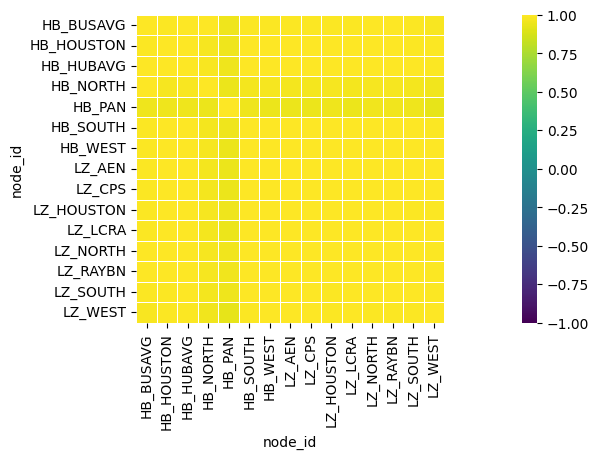

In [78]:
ercot_corr_matrix = lmp_corr_matrix(dataframe=ercot_main_hubs, 
                                    index='timestamp', columns='node_id')